<a href="https://colab.research.google.com/github/Miladatasys/cv-ml-comparison/blob/main/ml_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Construcción del Dataset

## Montaje Drive






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalación de librerías

In [ ]:
!pip install opencv-python-headless
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## Carga de imágenes con conversión a RGB y separación de canales

En este punto, cargamos y leemos las imágenes con OpenCV organizadas en subdirectorios correspondientes a las 3 clases distintas:

*   'with_mask',
*   'without_mask'
*   'mask_weared_incorrect'

Obtenemos una primera validación de que la lectura se realizó correctamente y que las etiquetas coinciden con las imágenes.



Número de imágenes cargadas: 81
Número de etiquetas cargadas: 81


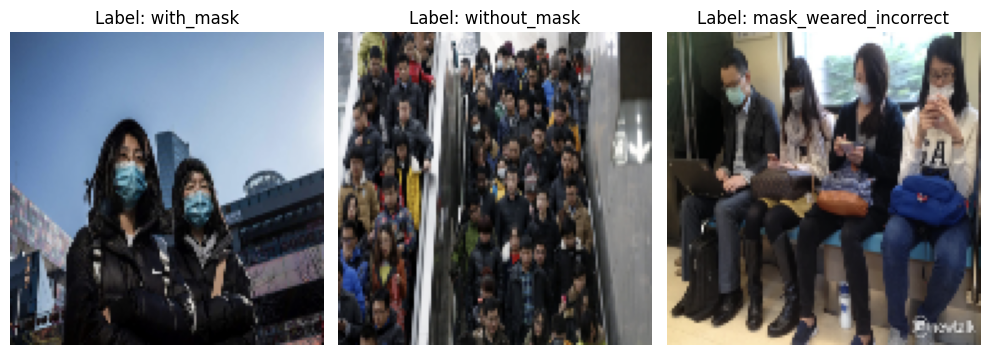

In [ ]:
import random  # Módulo random para obtención de imágenes

# Ruta al dataset
dataset_path = '/content/drive/MyDrive/ComputerVision/dataset/'

# Nombre de las clases que existen en el dataset
target_classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
example_images = {}

# Función para cargar imágenes
def load_images(path, size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, size)
                    images.append(image)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas
images, labels = load_images(dataset_path)
print("Número de imágenes cargadas:", len(images))
print("Número de etiquetas cargadas:", len(labels))

# Mostrar una imagen de ejemplo aleatoria de cada clase objetivo
fig, axes = plt.subplots(1, len(target_classes), figsize=(10, 5))
axes = axes.flatten()

for i, target_class in enumerate(target_classes):
    class_indices = [j for j, label in enumerate(labels) if label == target_class]
    if class_indices:
        # Seleccionar un índice aleatorio de las imágenes pertenecientes a esta clase
        random_index = random.choice(class_indices)
        axes[i].imshow(cv2.cvtColor(images[random_index], cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Label: {labels[random_index]}")
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f"No se encontraron ejemplos para: {target_class}", ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# 2.Preprocesamiento con OpenCV

## Operaciones morfológicas

Buscamos refinar las imágenes mediante operaciones morfológicas como dilatación y erosión luego de la conversión a escala de grises, además, elegimos un kernel de 4x4 intentando abordar el ruido y las discontinuidades de las imágenes de mascarillas de manera más efectiva, evitando la distorsión excesiva vista con un kernel de 5x5. Visualmente se percibe una sutil mejora en la conexión de regiones y reducción de ruido sin pérdida drástica de los detalles más importantes del rostro.

<Figure size 1200x400 with 0 Axes>

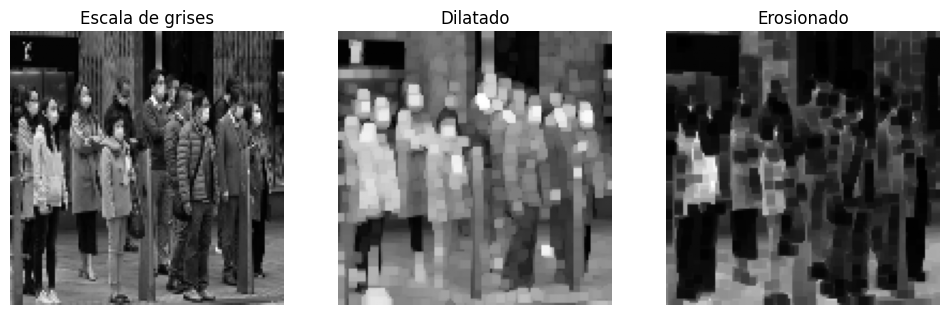

<Figure size 1200x400 with 0 Axes>

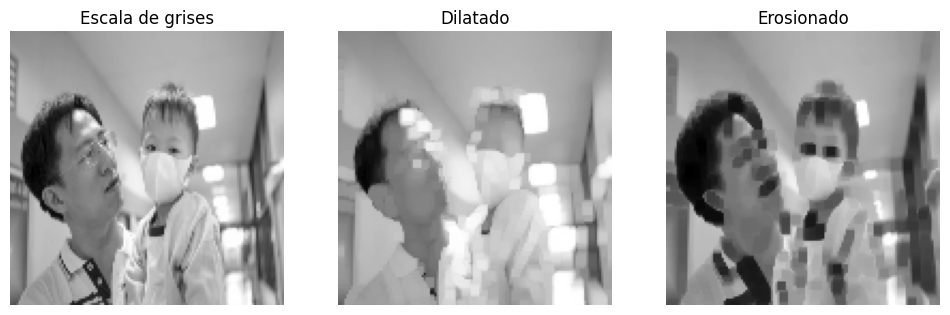

<Figure size 1200x400 with 0 Axes>

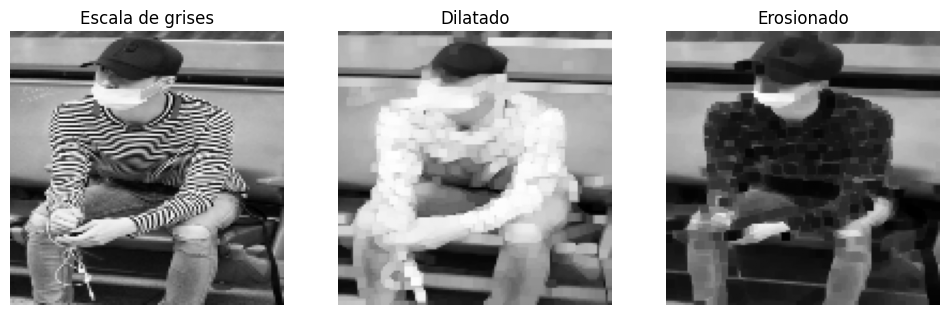

In [ ]:
# Convertir a escala de grises
def apply_morphological_operations(image, kernel_size=(5, 5)):

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  kernel = np.ones((4,4), np.uint8)
  dilated = cv2.dilate(gray, kernel, iterations=1)
  eroded = cv2.erode(gray, kernel, iterations=1)
  return gray, dilated, eroded

# Aplicar operaciones morfologicas a una imagen de cada clase
for cls in target_classes:
  # Seleccionar un índice aleatorio de esta clase
  indexes = [i for i, label in enumerate(labels) if label == cls]
  random_index = random.choice(indexes)
  image = images[random_index]

  # Aplicar morfología
  gray, dilated, eroded = apply_morphological_operations(image)

  # Mostrar

  plt.figure(figsize=(12, 4))
  plt.suptitle(f"Operaciones morfológicas - Clase: {cls}", fontsize=14)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.imshow(gray, cmap='gray')
  plt.title("Escala de grises")
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(dilated, cmap='gray')
  plt.title("Dilatado")
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(eroded, cmap='gray')
  plt.title("Erosionado")
  plt.axis('off')

  plt.show()

## Filtros convolucionales y segmentación / detección de contornos

En este paso buscamos extraer caracteristicas mediante filtros convolucionales y detección de contornos, comenzando con la conversión a escala de grises para reducir la complejidad y enfocarnos en la forma simplemente. Los filtros Sobel y Laplaciano resaltan bordes pero aumentan ruido, mientras que el Canny resalta los bordes haciendolos más refinados para detectar los contornos.

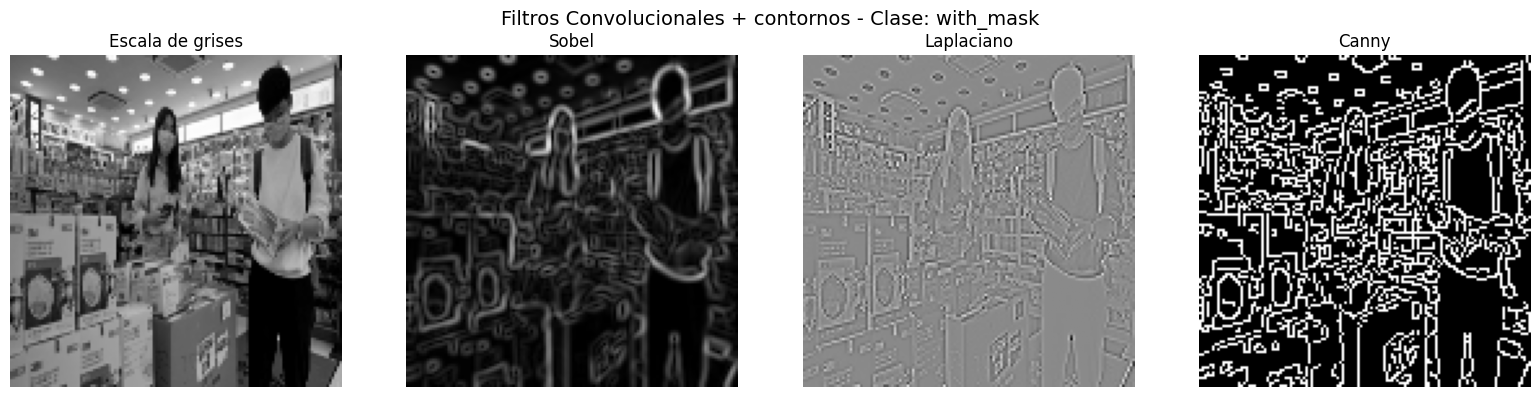

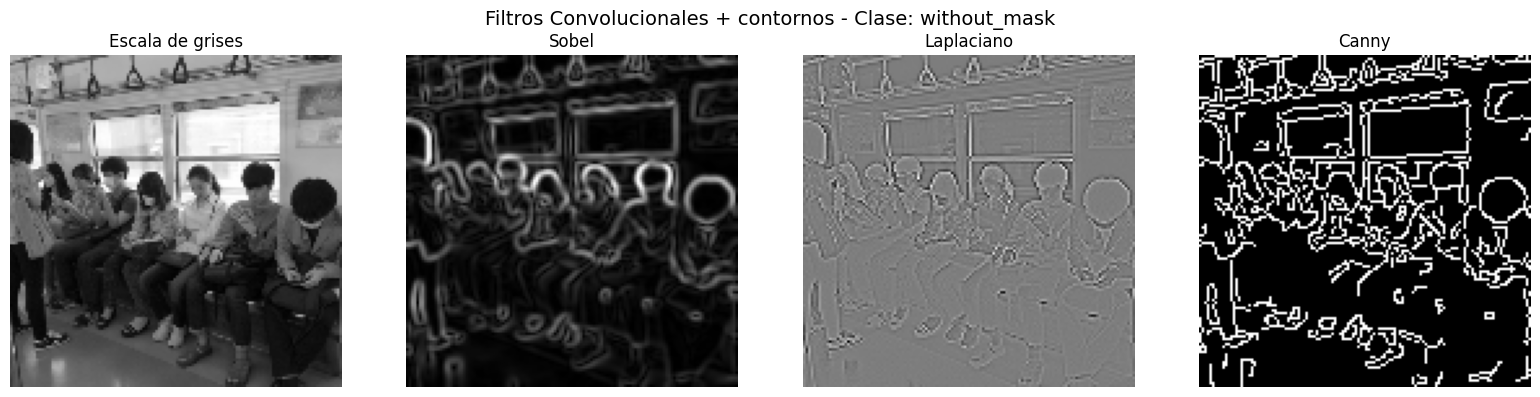

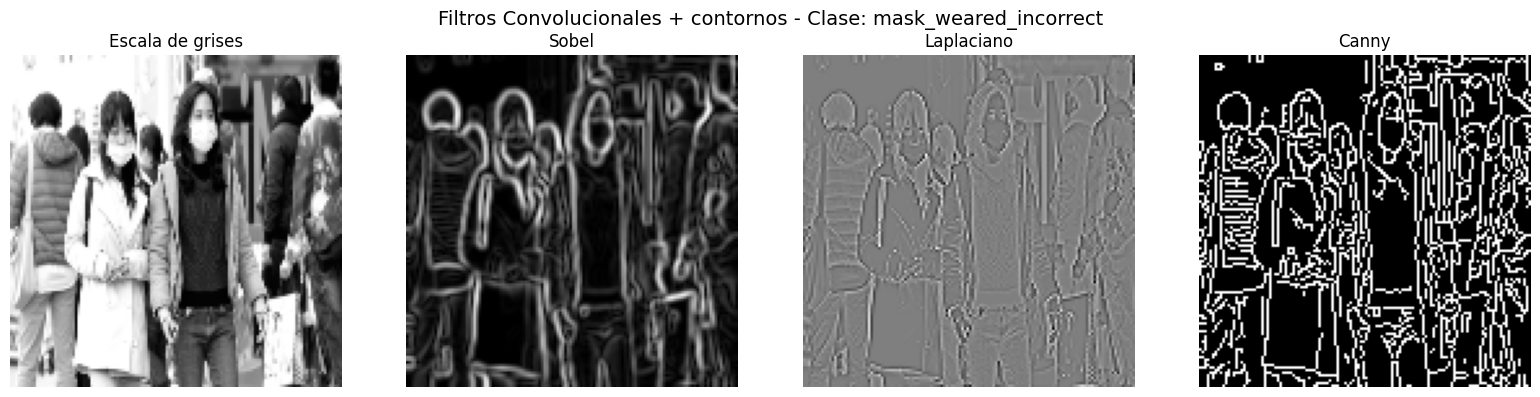

In [ ]:
# Función para aplicar los filtros
def apply_edge_detectors(image):
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Filtro Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  # horizontal
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  # vertical
    sobel_combined = cv2.magnitude(sobelx, sobely)

    # Filtro Laplaciano
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # Filtro Canny
    canny = cv2.Canny(gray, 100, 200)

    return gray, sobel_combined, laplacian, canny


# Aplicar filtros a una imagen de cada clase
for cls in target_classes:
    # Seleccionar un índice aleatorio de esta clase
    indexes = [i for i, label in enumerate(labels) if label == cls]
    random_index = random.choice(indexes)
    image = images[random_index]

    # Aplicar los filtros
    gray, sobel, laplacian, canny = apply_edge_detectors(image)

    # Detección de contornos
    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoured_img = image.copy()
    cv2.drawContours(contoured_img, contours, -1, (0, 255, 0), 2)

    # Mostrar resultados
    plt.figure(figsize=(16, 4))
    plt.suptitle(f"Filtros Convolucionales + contornos - Clase: {cls}", fontsize=14)

    plt.subplot(1, 4, 1)
    plt.imshow(gray, cmap='gray')
    plt.title("Escala de grises")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(sobel, cmap='gray')
    plt.title("Sobel")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(laplacian, cmap='gray')
    plt.title("Laplaciano")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(canny, cmap='gray')
    plt.title("Canny")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Suavizado / Reducción de ruido

Reducimos el ruido mediante filtros de suavizado, incluyendo promedio, gaussiano, mediana y bilateral, aplicados a imagenes de cada clase. La idea de esto es poder mejorar la calidad de las imagenes para etapas posteriores. Los filtros promedio y gaussiano tienden a difuminar los bordes de manera notable, lo que podría resultar perjudicial para detectar el uso de mascarillas, en contraste con el filtro de la mediana y bilateral que ofrecen una mejor respuesta reduciendo ruido y preservando los bordes de mejor manera.

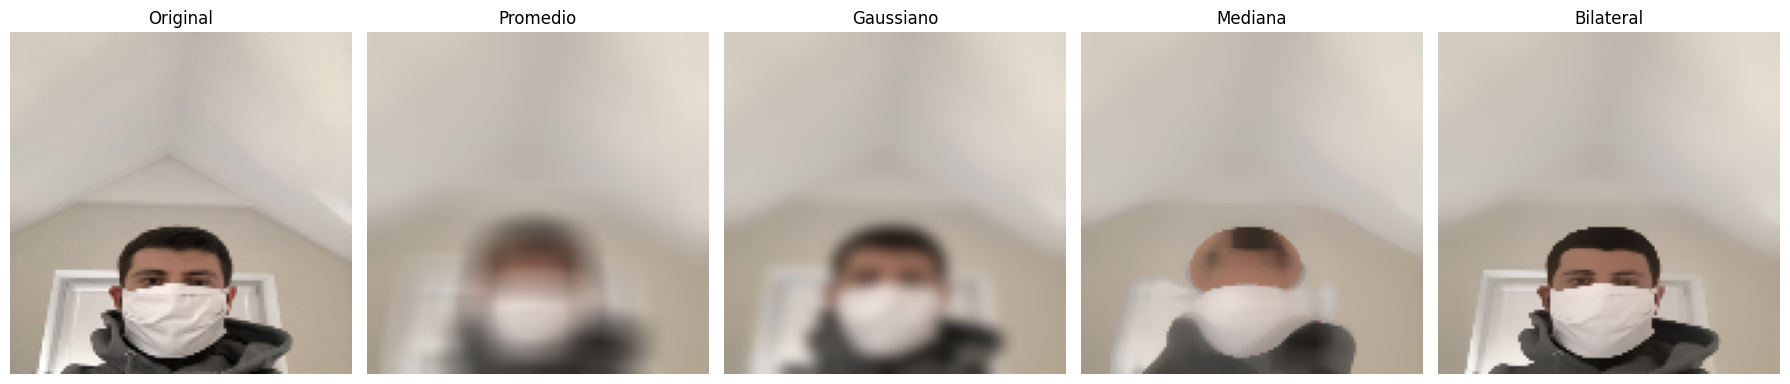

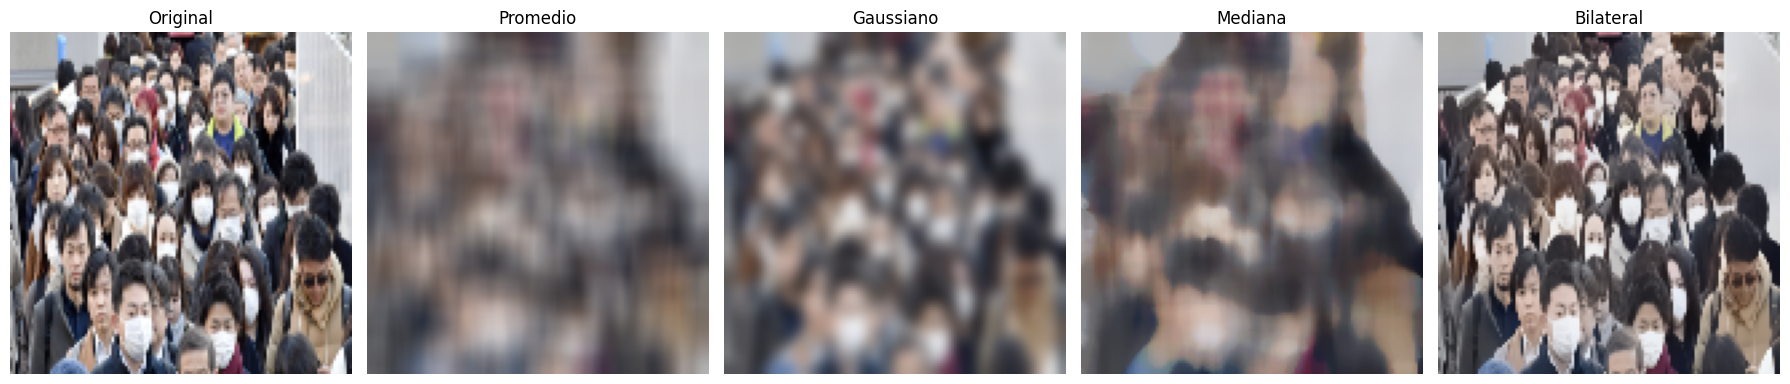

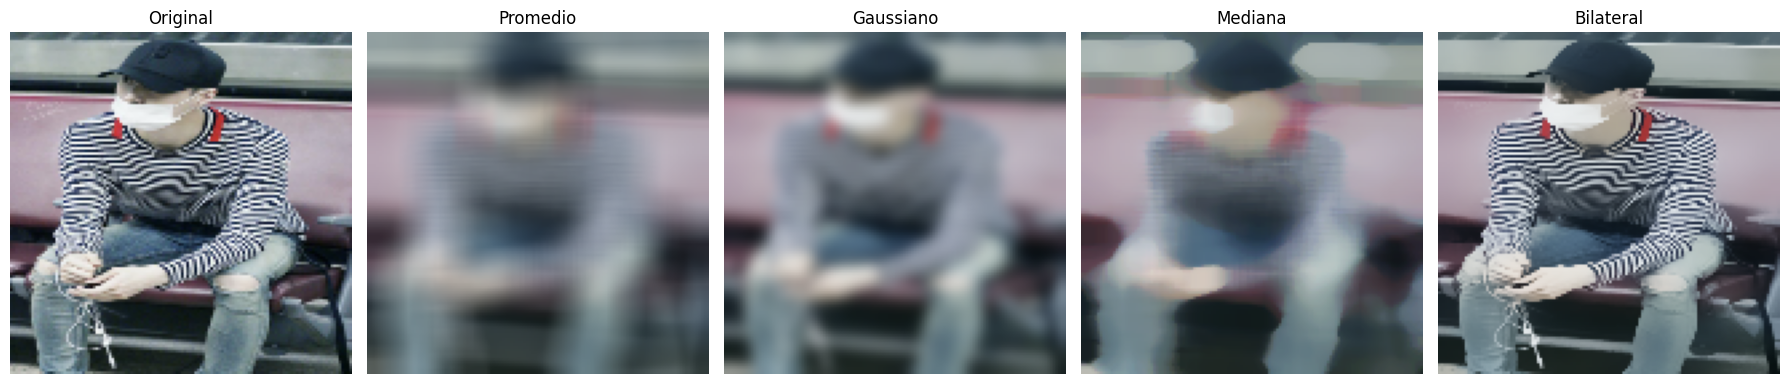

In [ ]:
# Función para mostrar imágenes lado a lado
def mostrar_imagenes(titulos, imagenes):
    plt.figure(figsize=(18,5))
    for i in range(len(imagenes)):
        plt.subplot(1, len(imagenes), i+1)
        img = imagenes[i]
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB
        else:
            plt.imshow(img, cmap='gray')
        plt.title(titulos[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Aplicar suavizados a una imagen por clase
for cls in target_classes:
    indexes = [i for i, label in enumerate(labels) if label == cls]
    random_index = random.choice(indexes)
    image = images[random_index]

    # Filtros de suavizado
    promedio = cv2.blur(image, (15, 15))
    gauss = cv2.GaussianBlur(image, (15, 15), 0)
    mediana = cv2.medianBlur(image, 15)
    bilateral = cv2.bilateralFilter(image, 15, 75, 75)

    # Mostrar
    mostrar_imagenes(
        ['Original', 'Promedio', 'Gaussiano', 'Mediana', 'Bilateral'],
        [image, promedio, gauss, mediana, bilateral]
    )

## Histogramas

El análisis de los distintos histogramas nos indica que la ecualización es la técnica más consistente y efectiva para mejorar el constraste en las tres clases. En cada aso, la imagen ecualizada presenta una mayor distinción de detalles en comparación con la imagen original. Por otro lado, el estiramiento de contraste resultó ser una técnica inadecuada para el dataset, por la distribución original de la intensidad en los pixeles y llevó a una pérdida de información y sin detalles visibles, concentrando la mayoría de los píxeles en los extremos del rango de intensidad. Por lo tanto, la ecualización se perfila como la mejor técnica para mejorar la calidad del contraste en las imagenes y finalmente para clasificar el uso de mascarilla.

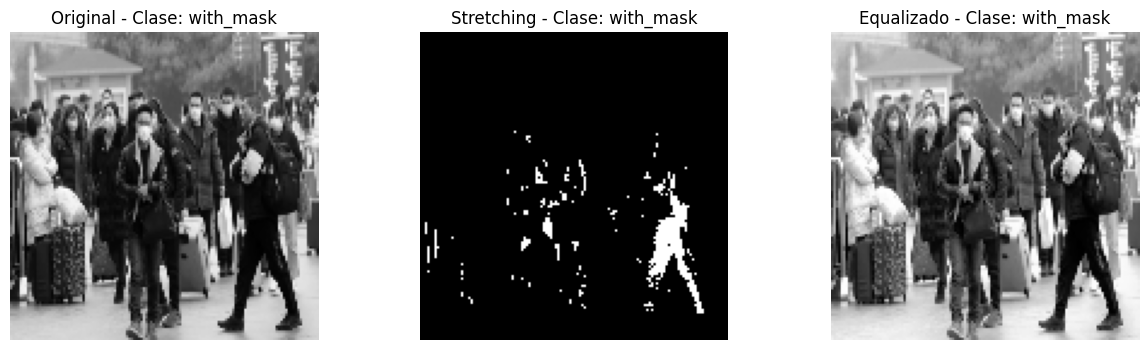

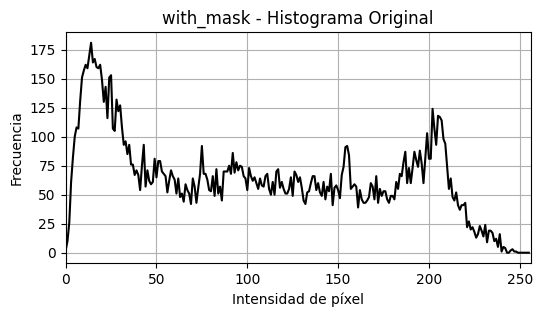

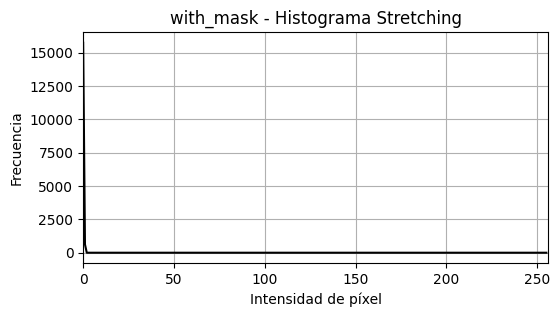

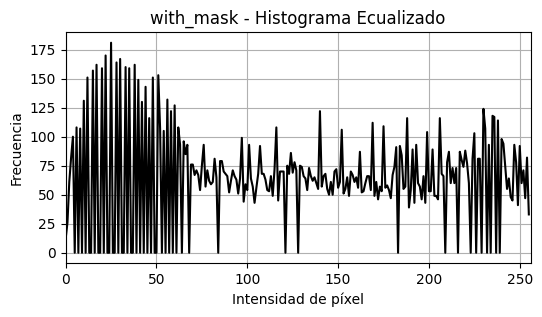

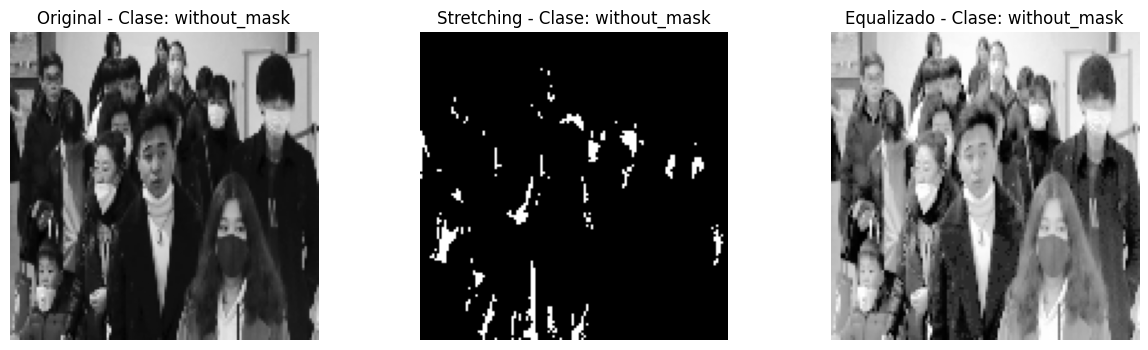

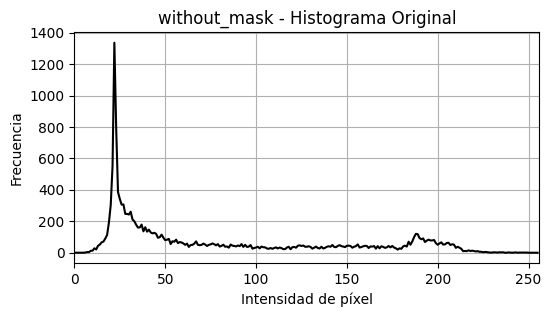

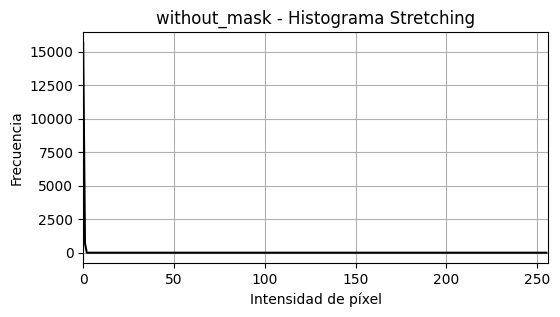

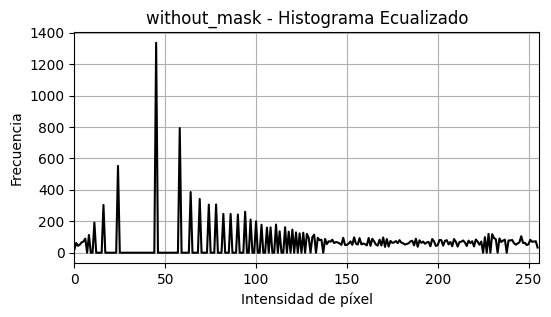

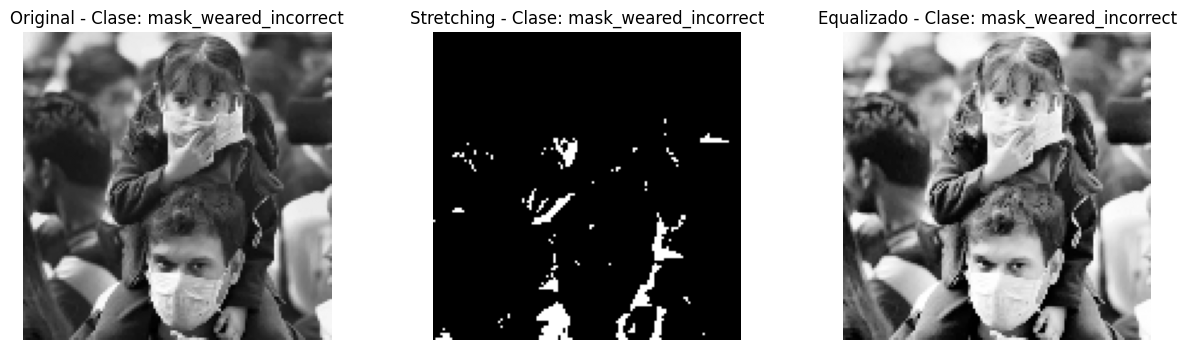

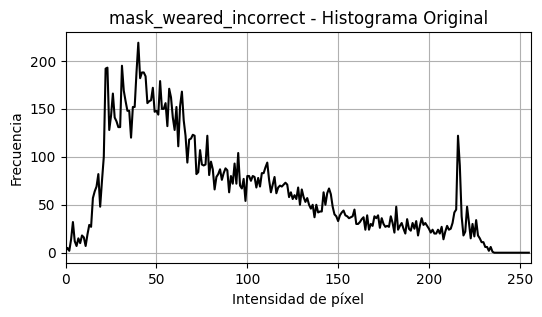

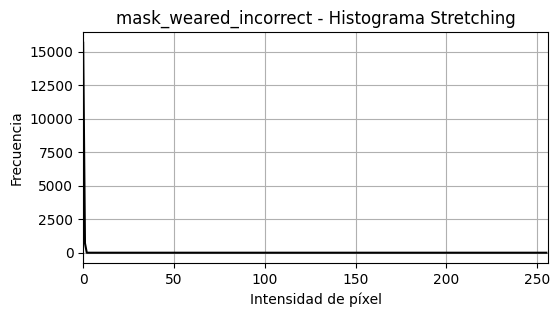

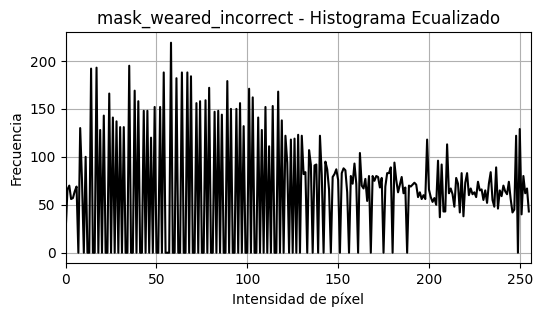

In [ ]:
def graficar_histograma(img, titulo):
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    plt.figure(figsize=(6, 3))
    plt.title(titulo)
    plt.plot(hist, color='black')
    plt.xlabel('Intensidad de píxel')
    plt.ylabel('Frecuencia')
    plt.xlim([0,256])
    plt.grid()
    plt.show()

# Aplicar análisis de histograma a una imagen por clase
for cls in target_classes:
    indexes = [i for i, label in enumerate(labels) if label == cls]
    random_index = random.choice(indexes)
    image = images[random_index]

    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Estiramiento de contraste
    min_val = np.min(gray)
    max_val = np.max(gray)
    stretch = ((gray - min_val) * 255 / (max_val - min_val)).astype('uint8')

    # Ecualización
    equalized = cv2.equalizeHist(gray)

    # Mostrar imágenes
    plt.figure(figsize=(15, 4))
    titulos = ['Original', 'Stretching', 'Equalizado']
    imagenes = [gray, stretch, equalized]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(imagenes[i], cmap='gray')
        plt.title(f"{titulos[i]} - Clase: {cls}")
        plt.axis('off')
    plt.show()

    # Mostrar histogramas
    graficar_histograma(gray, f"{cls} - Histograma Original")
    graficar_histograma(stretch, f"{cls} - Histograma Stretching")
    graficar_histograma(equalized, f"{cls} - Histograma Ecualizado")

## Descriptores

In [ ]:
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
import cv2
import numpy as np

# Parámetros HOG
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
}

# Parámetros LBP
lbp_radius = 1
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'

# Inicializar ORB
orb = cv2.ORB_create()

# Diccionarios para almacenar características por tipo
features_hog = []
features_lbp = []
features_orb = []
labels_all = []

# Recorrer imágenes
for img, label in zip(images, labels):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ---- HOG ----
    hog_feat = hog(gray, visualize=False, **hog_params)
    features_hog.append(hog_feat)

    # ---- LBP ----
    lbp = local_binary_pattern(gray, lbp_n_points, lbp_radius, method=lbp_method)
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_n_points + 3), range=(0, lbp_n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    features_lbp.append(hist)

    # ---- ORB ----
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    if descriptors is not None:
        orb_desc = descriptors.flatten()
        if orb_desc.shape[0] < 500:  # (rellenar con ceros)
            orb_desc = np.pad(orb_desc, (0, 500 - orb_desc.shape[0]), mode='constant')
        else:
            orb_desc = orb_desc[:500]  # Cortar si es muy largo
    else:
        orb_desc = np.zeros(500)
    features_orb.append(orb_desc)

    labels_all.append(label)

# Convertir a arrays
features_hog = np.array(features_hog)
features_lbp = np.array(features_lbp)
features_orb = np.array(features_orb)
labels_all = np.array(labels_all)

# Normalización
scaler_hog = StandardScaler().fit_transform(features_hog)
scaler_lbp = StandardScaler().fit_transform(features_lbp)
scaler_orb = StandardScaler().fit_transform(features_orb)

# Mostrar tamaños
print("Shape HOG:", scaler_hog.shape)
print("Shape LBP:", scaler_lbp.shape)
print("Shape ORB:", scaler_orb.shape)

Shape HOG: (81, 8100)
Shape LBP: (81, 10)
Shape ORB: (81, 500)
